### Import

In [1]:
from evaluation import *
from data_loader import *
import random
from datetime import datetime

### Get Config
Note that the below cell fetches all of the config data which is also used to train the models. This code will not run if you have not already completed a training simulation at some point with the same config parameters. If you have run the training already, you can set the `train_model` parameter in the `evaluation_congfig.yaml` file to `False` so that you can get the results without having to run the training again.

In [2]:
neural_network_config_fname = 'configs/neural_network_config.yaml'
algorithm_config_fname = 'configs/algorithm_config.yaml'
environment_config_fname = 'configs/environment_config.yaml'
eval_config_fname = 'configs/evaluation_config.yaml'

c = load_config_file(neural_network_config_fname)
nn_c = c['nn_hyperparameters']
c = load_config_file(algorithm_config_fname)
algo_c = c['algorithm_settings']
c = load_config_file(environment_config_fname)
env_c = c['environment_settings']
c = load_config_file(eval_config_fname)
eval_c = c['eval_config']

if eval_c['fixed_attributes'] != [0, 1] and eval_c['fixed_attributes'] != [1, 0] and eval_c['fixed_attributes'] != [0.5, 0.5]:
    attr_label = 'learned'
else:
    fixed_attributes = eval_c['fixed_attributes']
    attr_label = f'{fixed_attributes[0]}_{fixed_attributes[1]}'

current_datetime = datetime.now()
date = current_datetime.strftime('%Y-%m-%d_%H-%M')

### Get EV Info

In [3]:
ev_info = []

for seed in env_c['seeds']:

    # Assign seed
    random.seed(seed)
    # Creating and seeding a random generaton from Numpy
    rng = np.random.default_rng(seed)

    for _ in env_c['coords']:
        # Generate a random model index for each agent
        model_indices = np.array([random.randrange(3) for agent in range(env_c['num_of_agents'])], dtype=int)

        # Use the indices to select the model type and corresponding configurations
        model_type = np.array([env_c['models'][index] for index in model_indices], dtype=str)
        usage_per_hour = np.array([env_c['usage_per_hour'][index] for index in model_indices], dtype=int)
        max_charge = np.array([env_c['max_charge'][index] for index in model_indices], dtype=int)

        start_time = time.time()
        # Random charge between 0.5-x%, where x scales between 1-25% as sessions continue
        starting_charge = env_c['starting_charge'] + 2000*(rng.random(env_c['num_of_agents'])-0.5)
        elapsed_time = time.time() - start_time

        # Define a structured array
        dtypes = [('starting_charge', float),
                  ('max_charge', int),
                  ('usage_per_hour', int),
                  ('model_type', 'U50'),  # Adjust string length as needed
                  ('model_indices', int)]
        info = np.zeros(env_c['num_of_agents'], dtype=dtypes)

        # Assign values
        info['starting_charge'] = starting_charge
        info['max_charge'] = max_charge
        info['usage_per_hour'] = usage_per_hour
        info['model_type'] = model_type
        info['model_indices'] = model_indices

        ev_info.append(info)

### Visualize

Evaluating Distance Travelled (km) Metrics for seed 1234


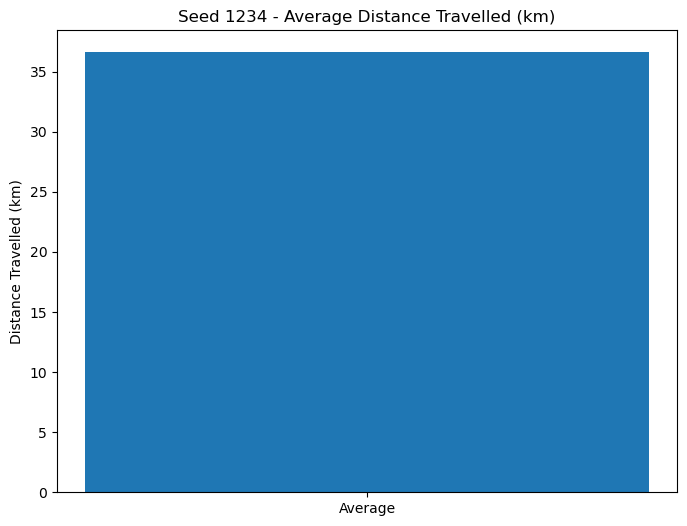

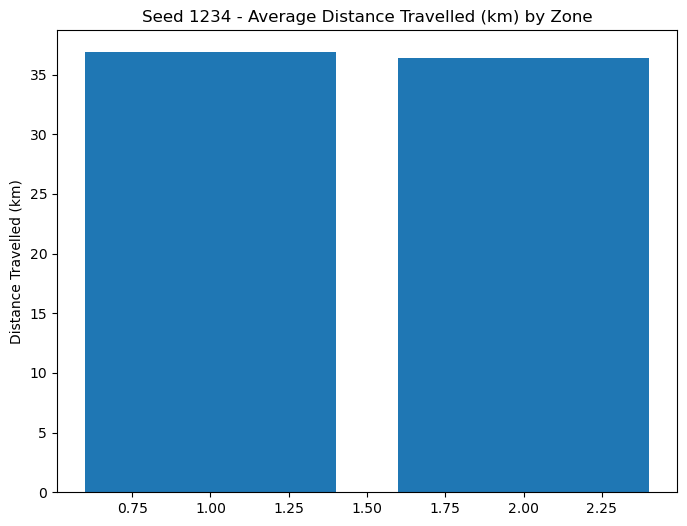

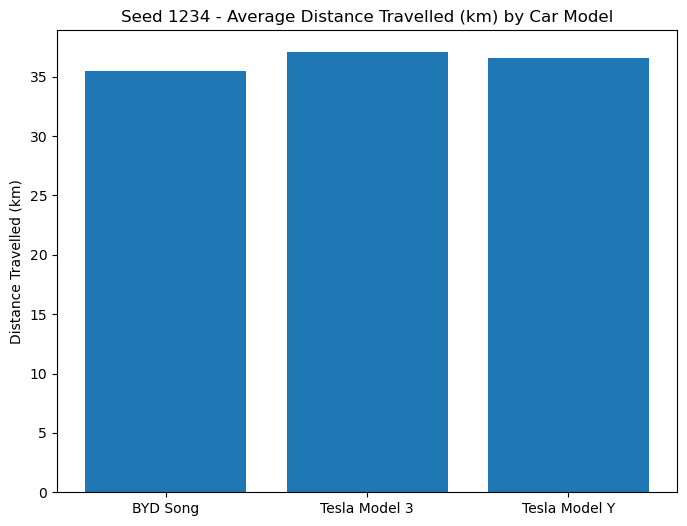

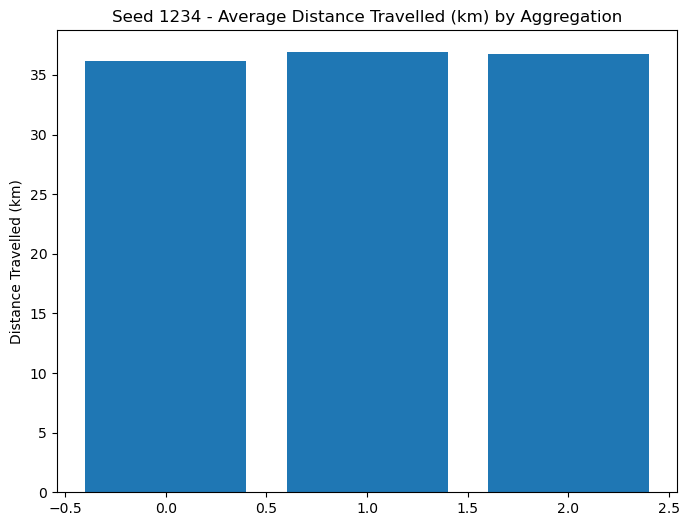

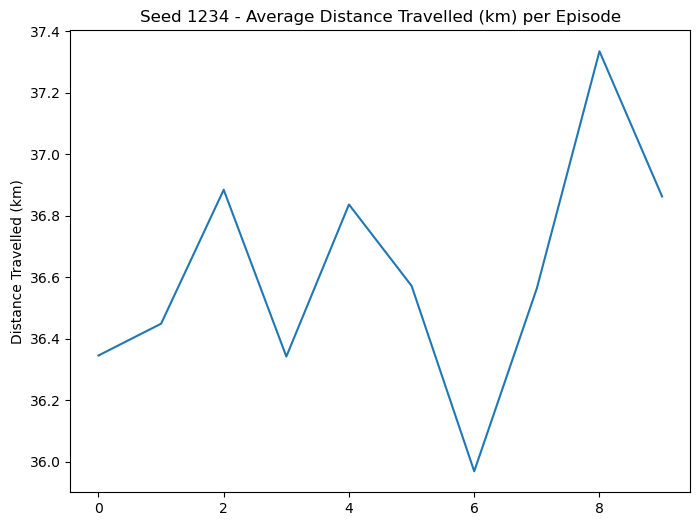

<Figure size 800x600 with 0 Axes>

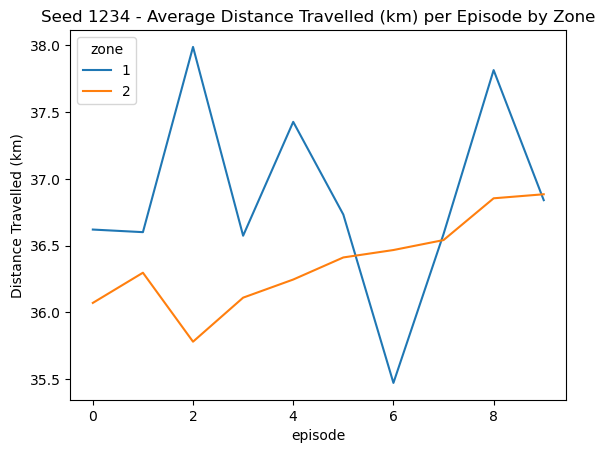

<Figure size 800x600 with 0 Axes>

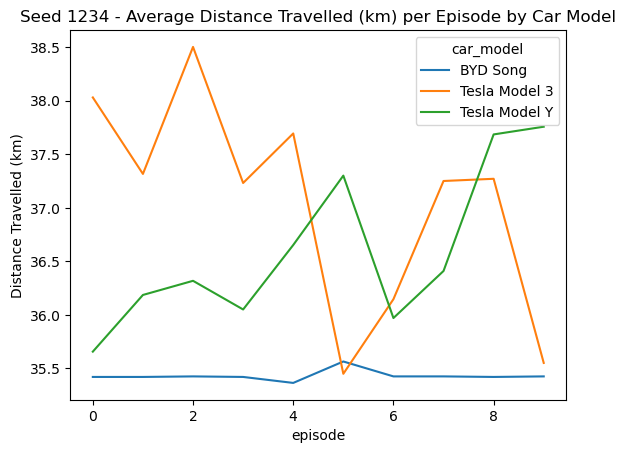

<Figure size 800x600 with 0 Axes>

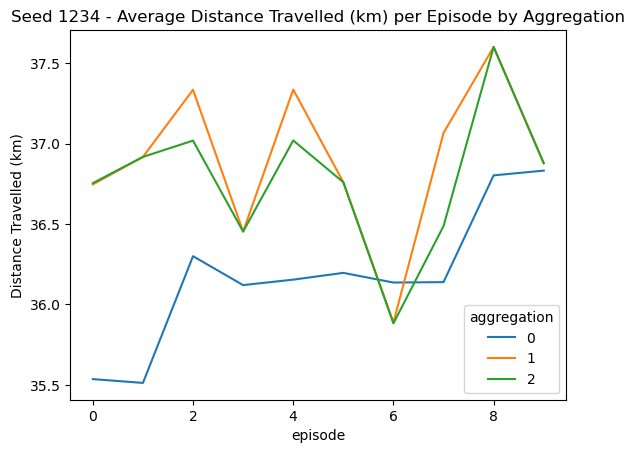

Evaluating Battery Level (Watts) Metrics for seed 1234


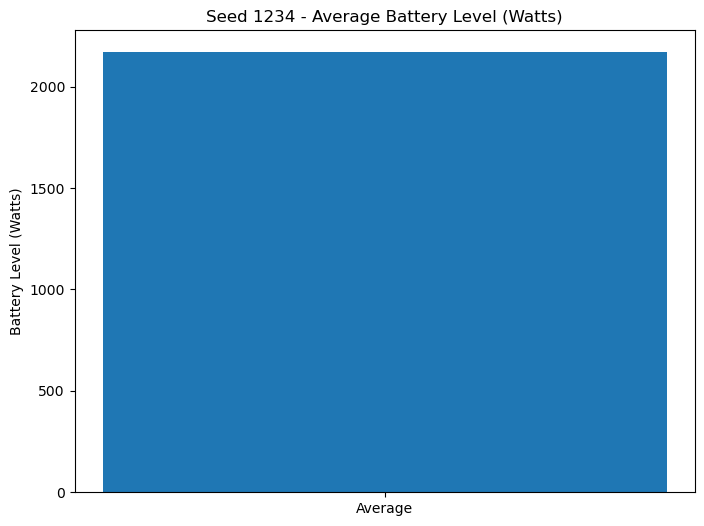

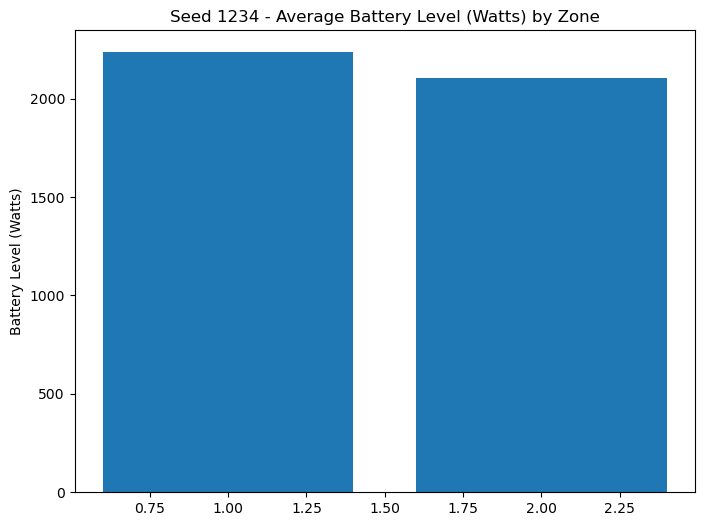

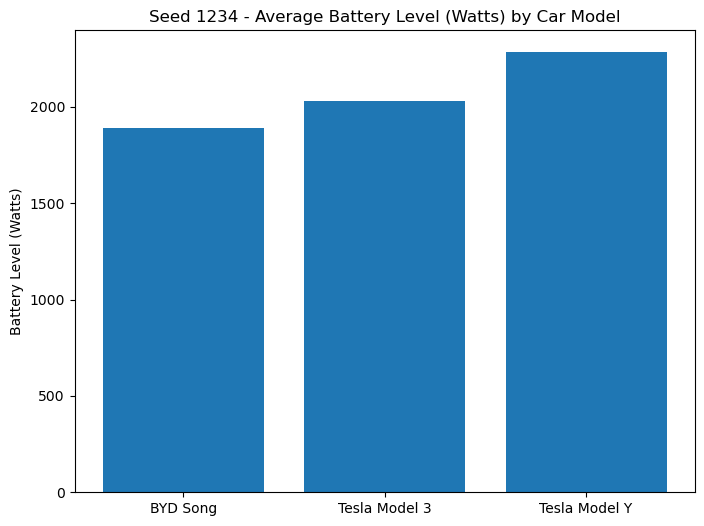

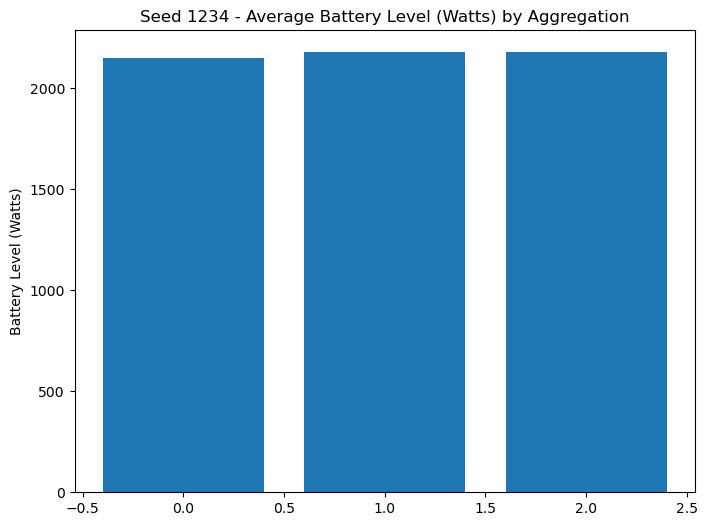

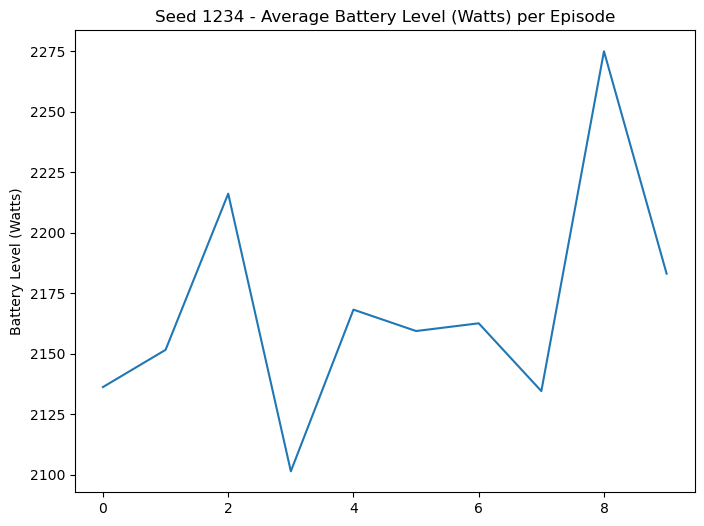

<Figure size 800x600 with 0 Axes>

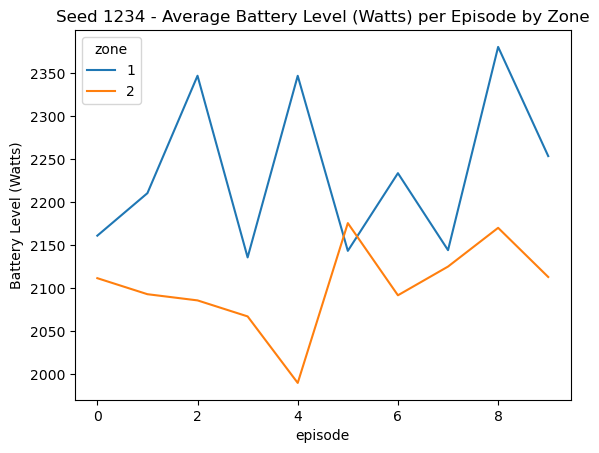

<Figure size 800x600 with 0 Axes>

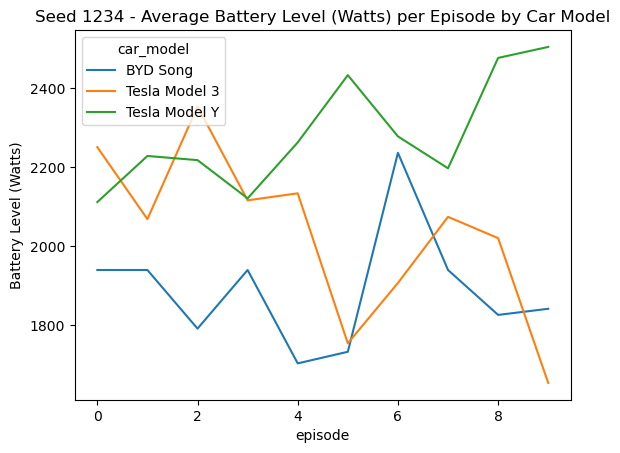

<Figure size 800x600 with 0 Axes>

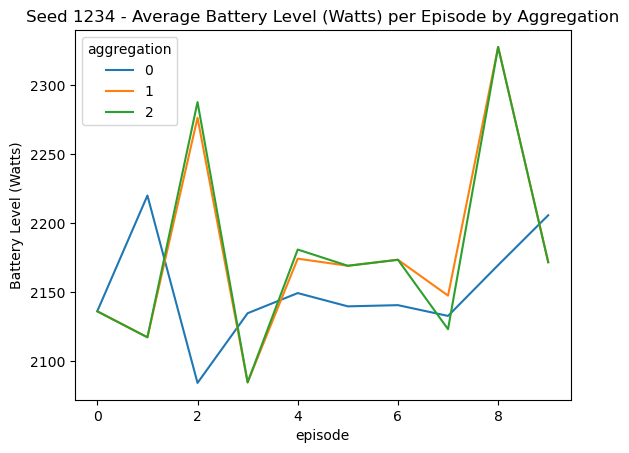

Evaluating Ending Battery Level (Watts) Metrics for seed 1234


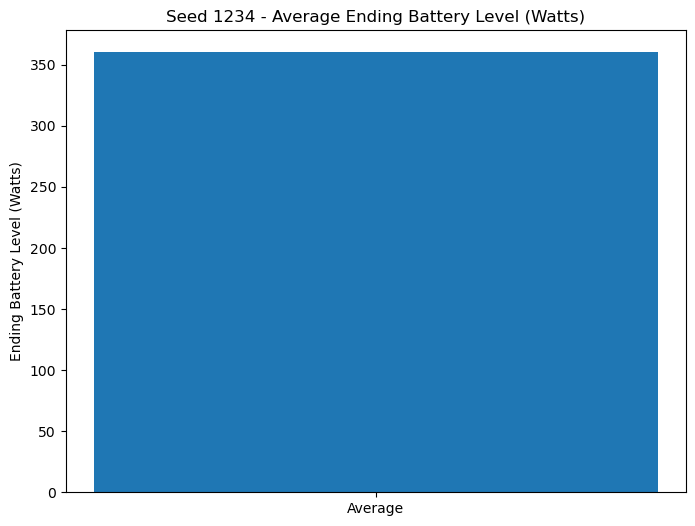

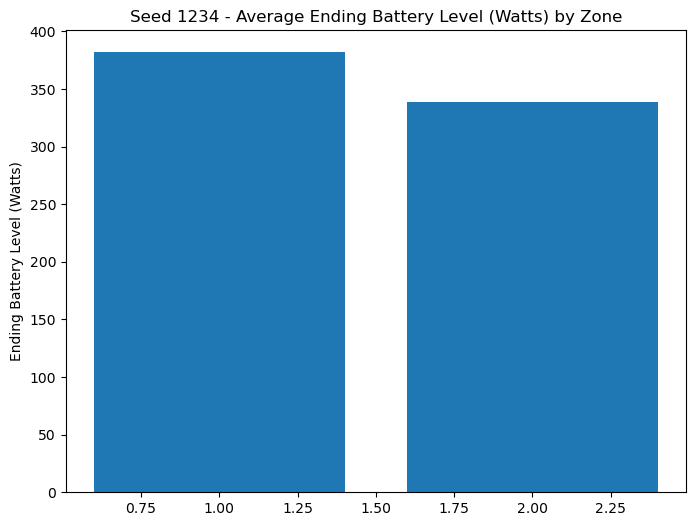

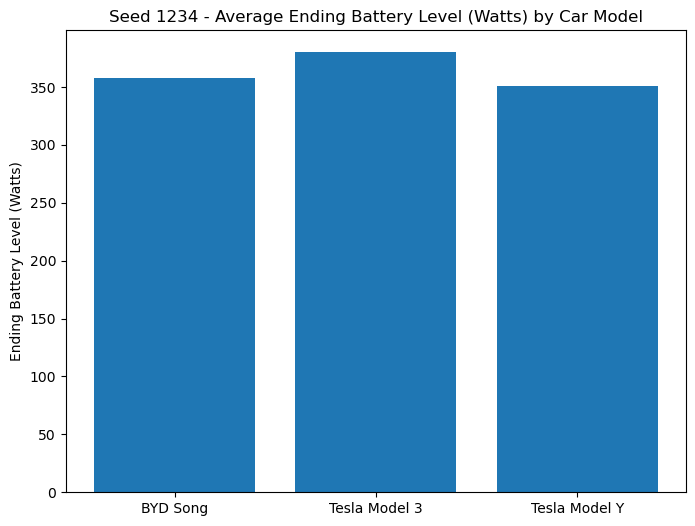

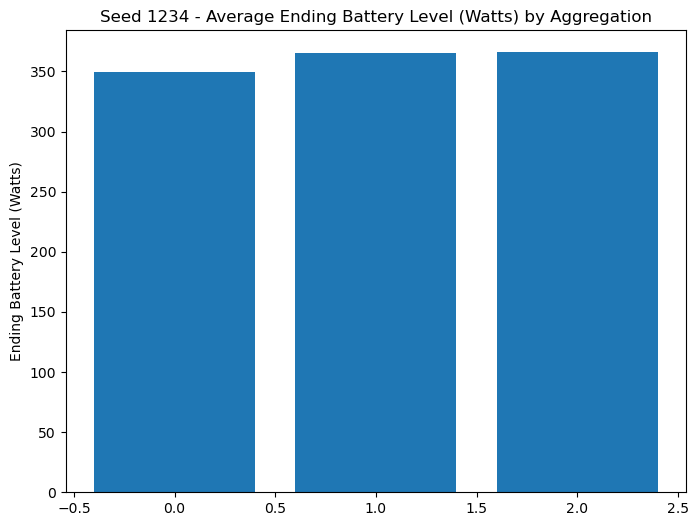

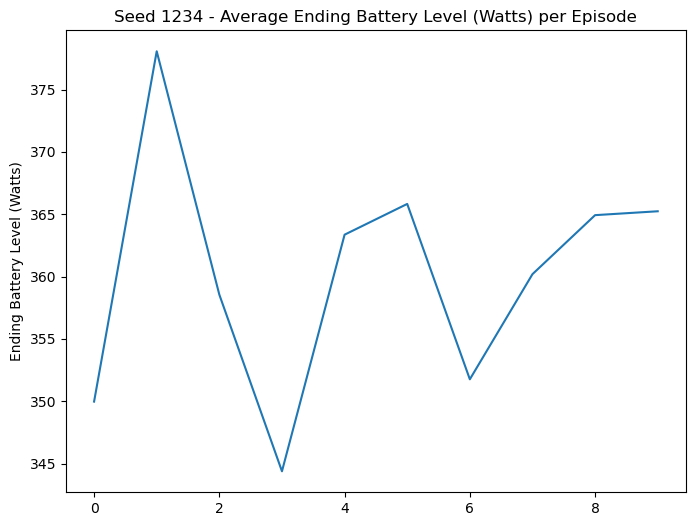

<Figure size 800x600 with 0 Axes>

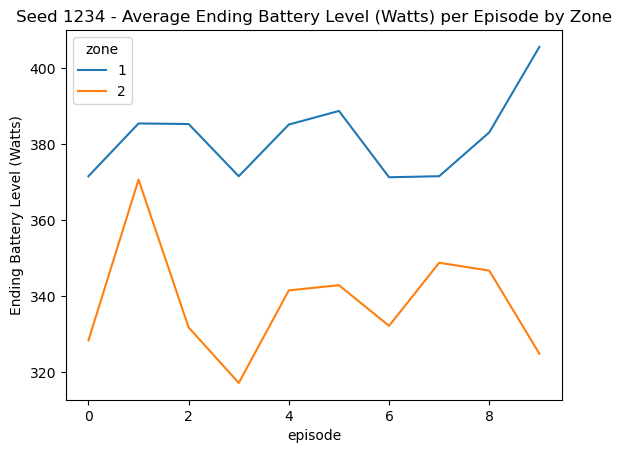

<Figure size 800x600 with 0 Axes>

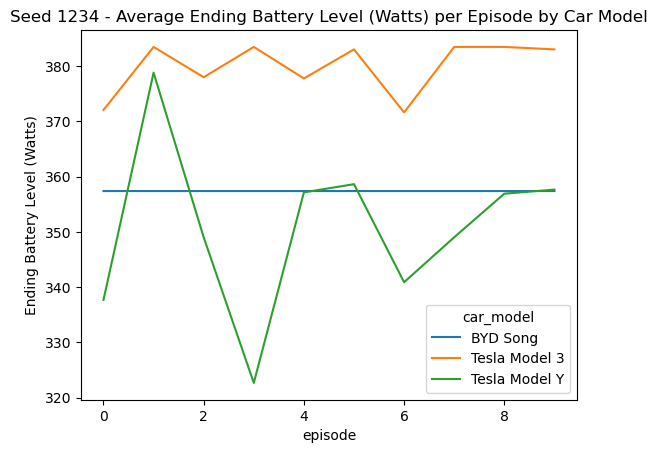

<Figure size 800x600 with 0 Axes>

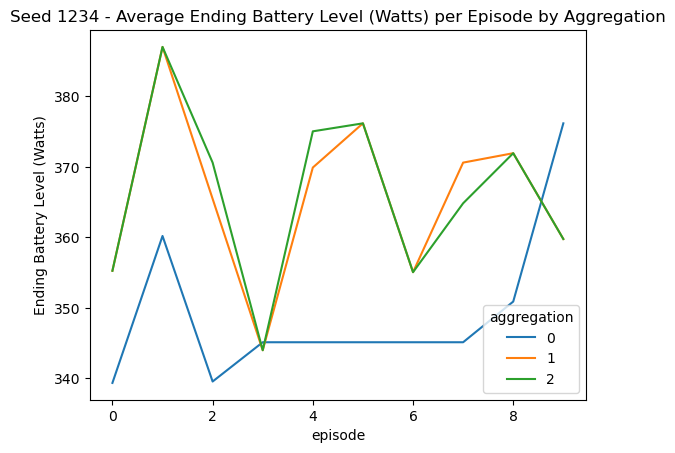

Evaluating Time Spent Travelling (Steps) Metrics for seed 1234


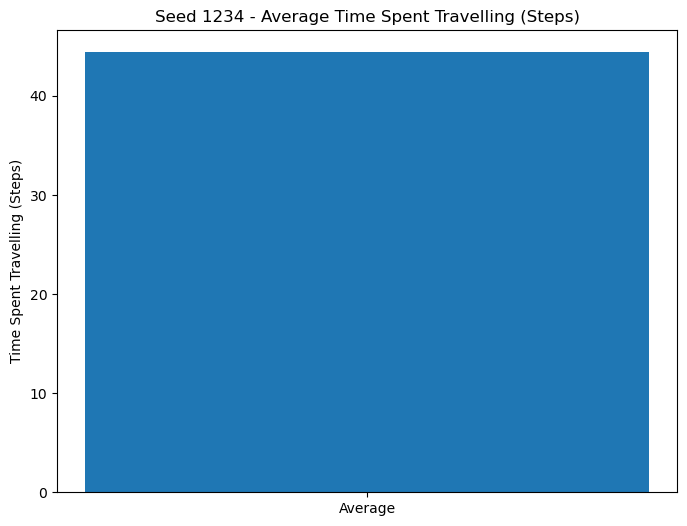

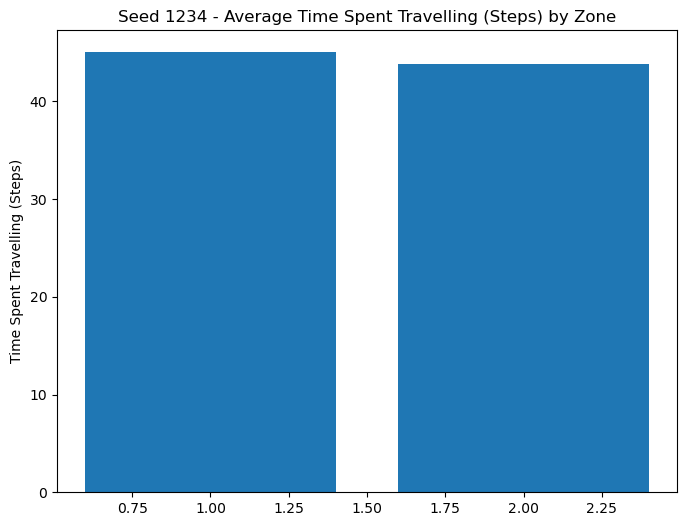

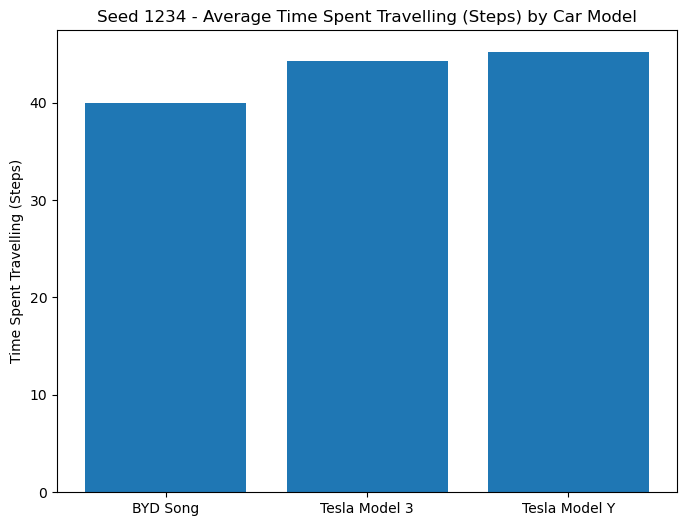

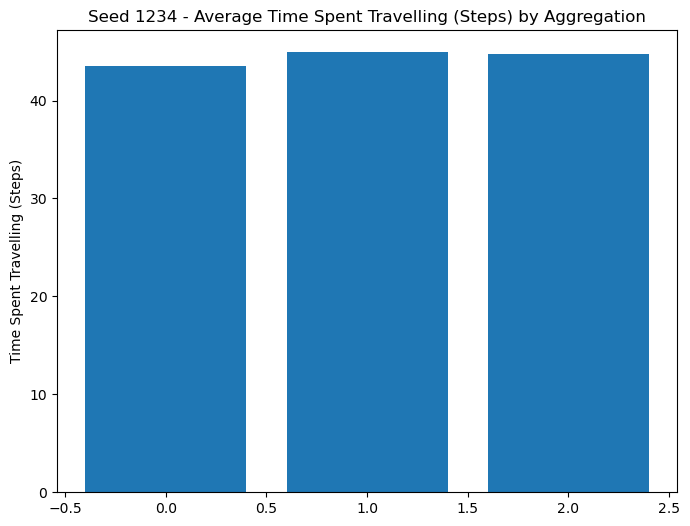

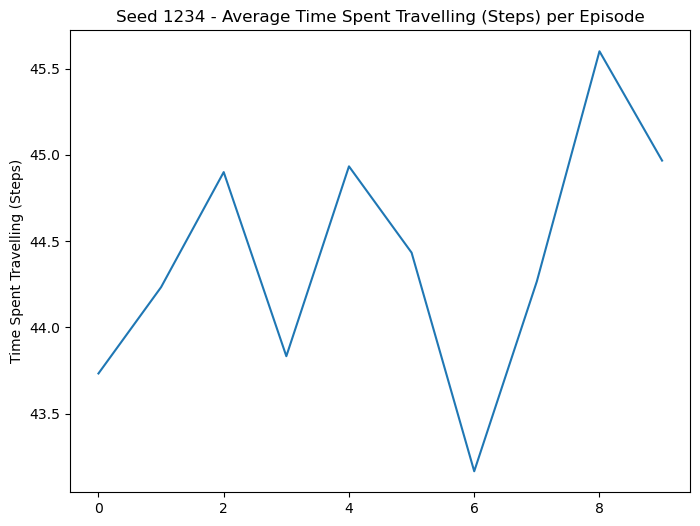

<Figure size 800x600 with 0 Axes>

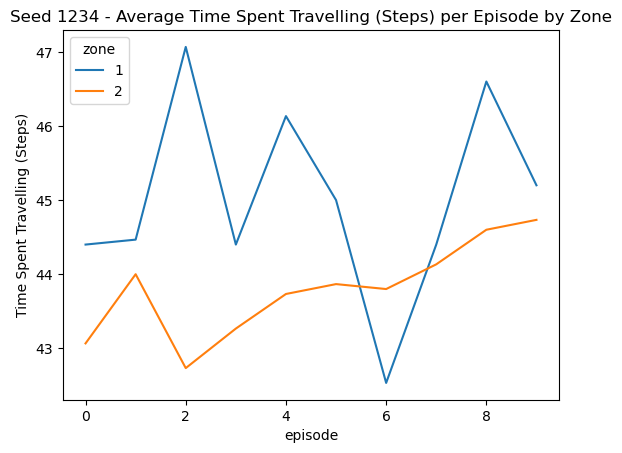

<Figure size 800x600 with 0 Axes>

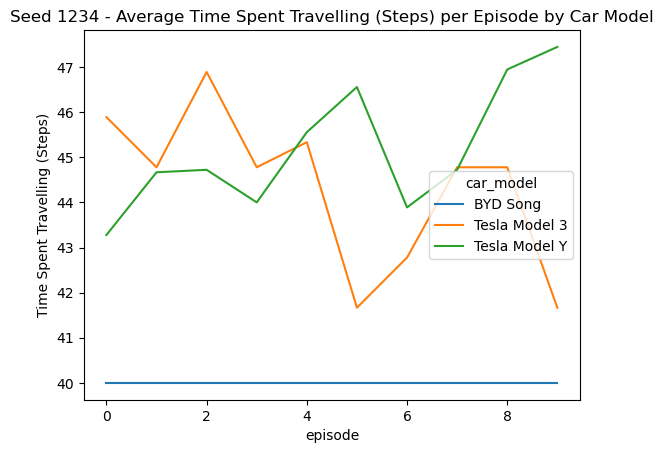

<Figure size 800x600 with 0 Axes>

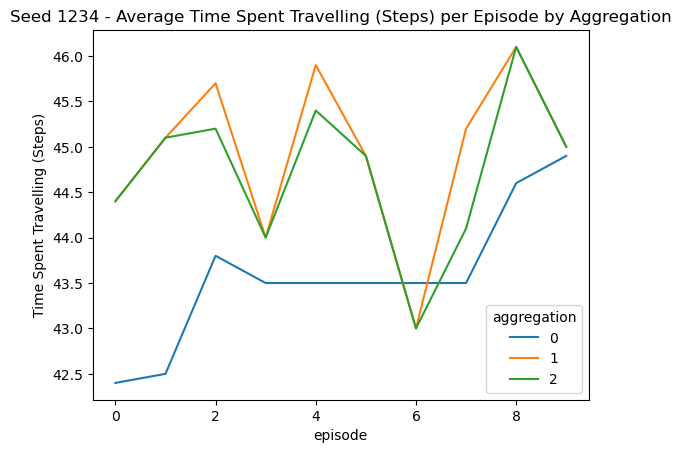

Evaluating Simulation Reward Metrics for seed 1234


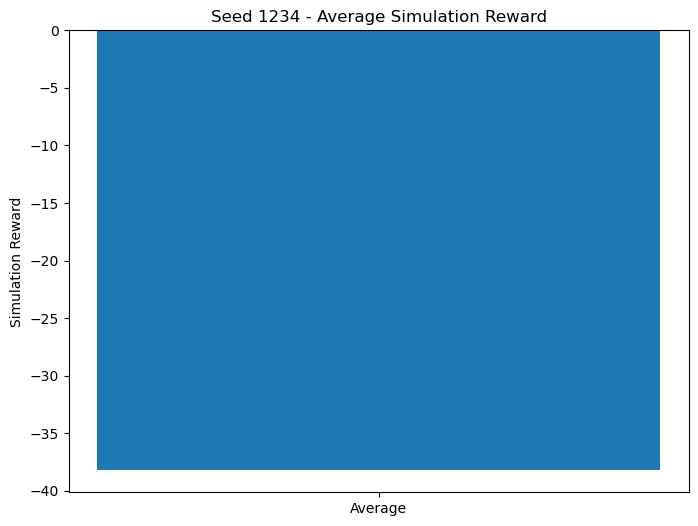

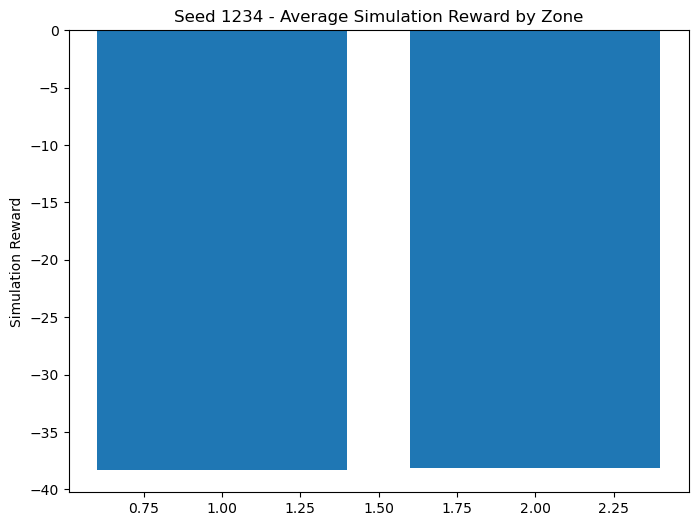

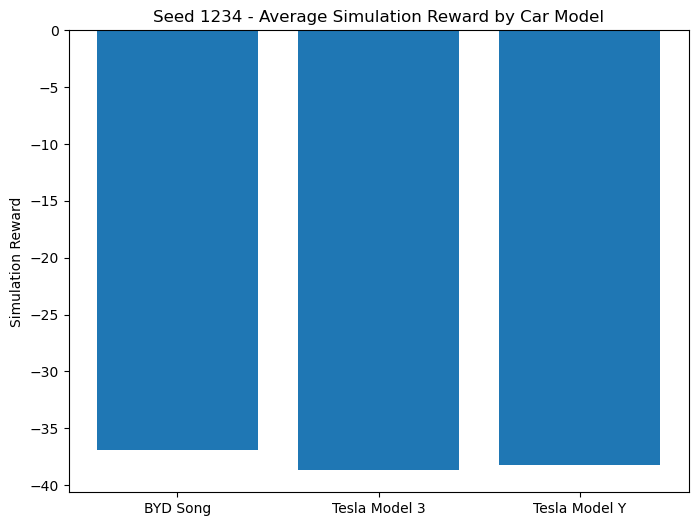

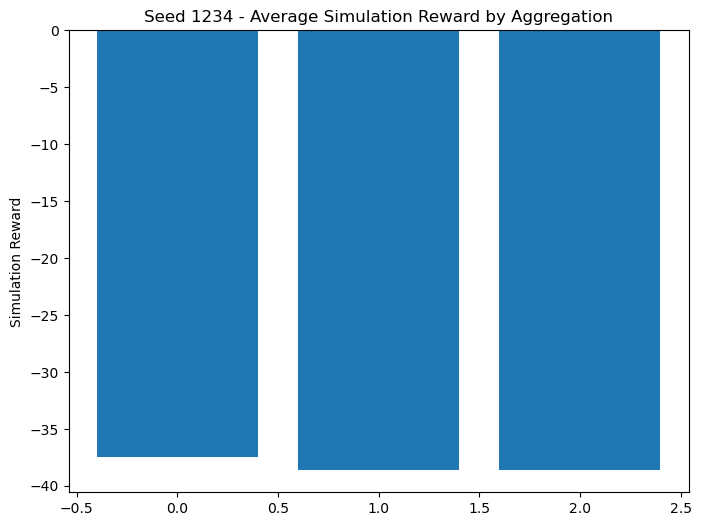

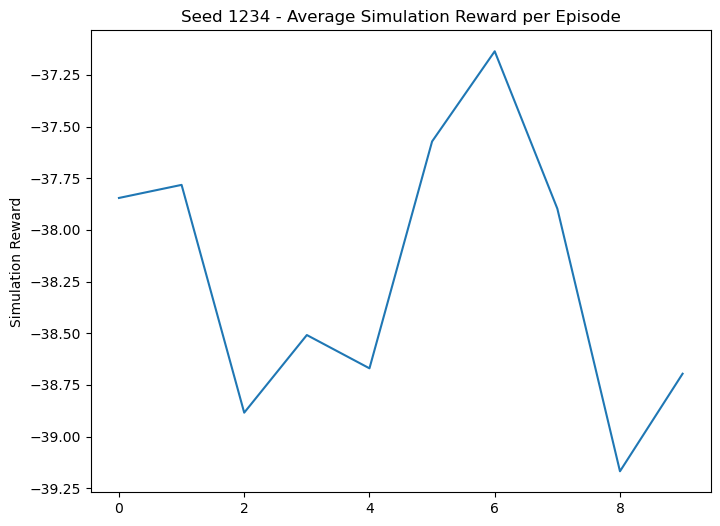

<Figure size 800x600 with 0 Axes>

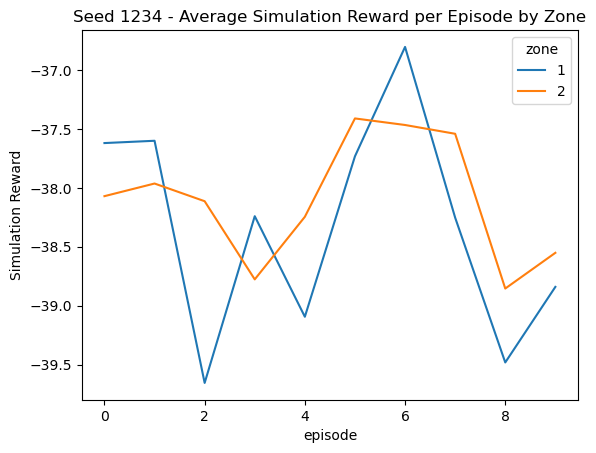

<Figure size 800x600 with 0 Axes>

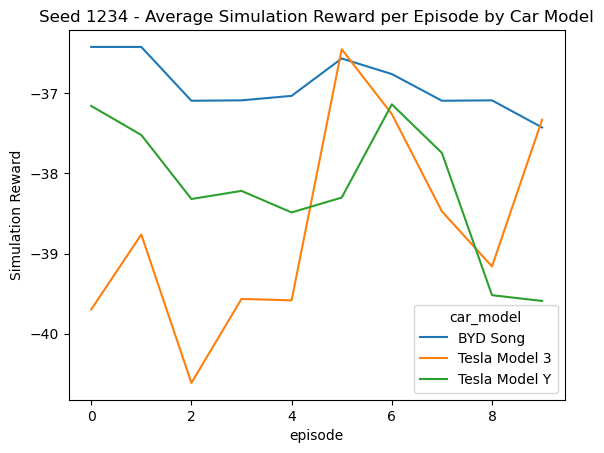

<Figure size 800x600 with 0 Axes>

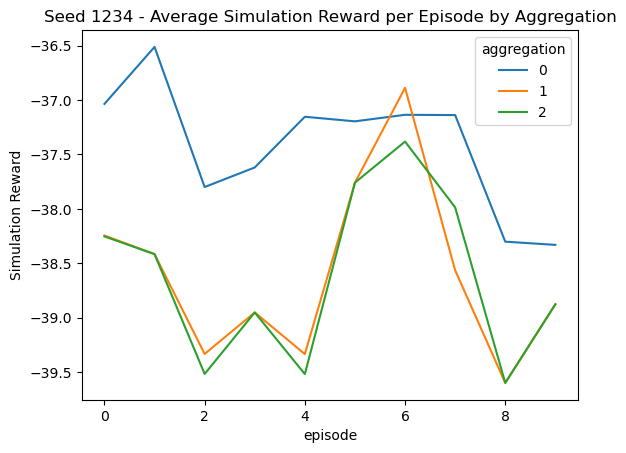

Evaluating Traffic Metrics


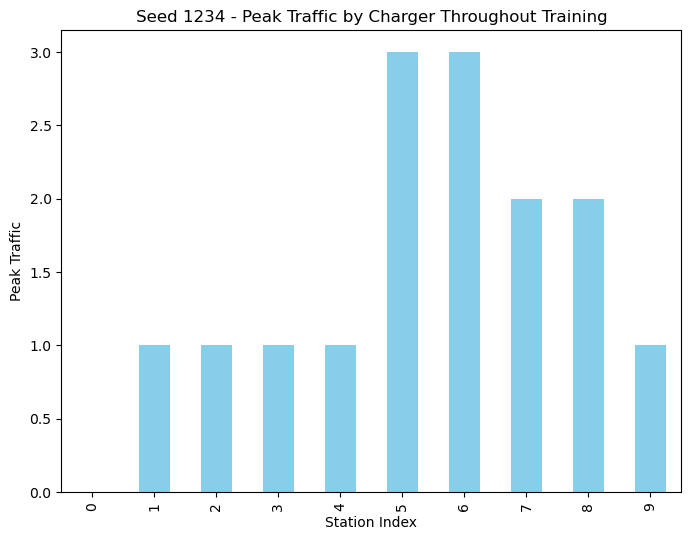

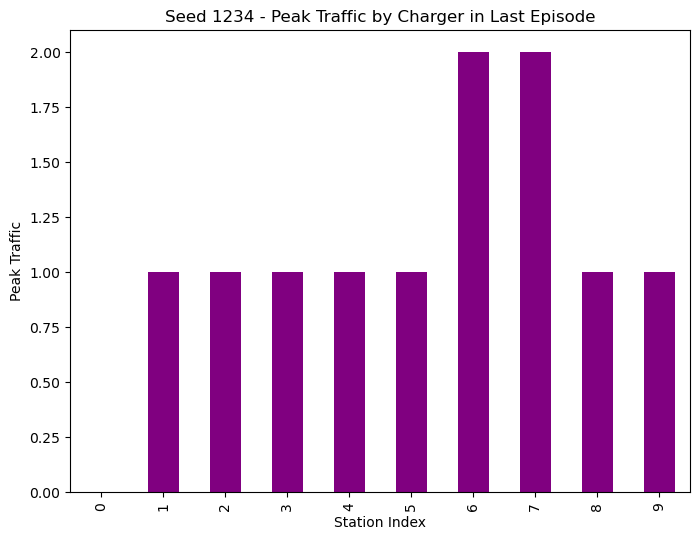

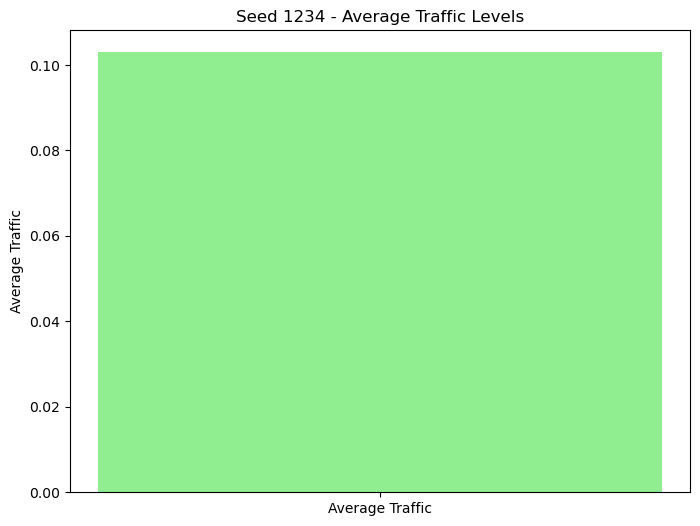

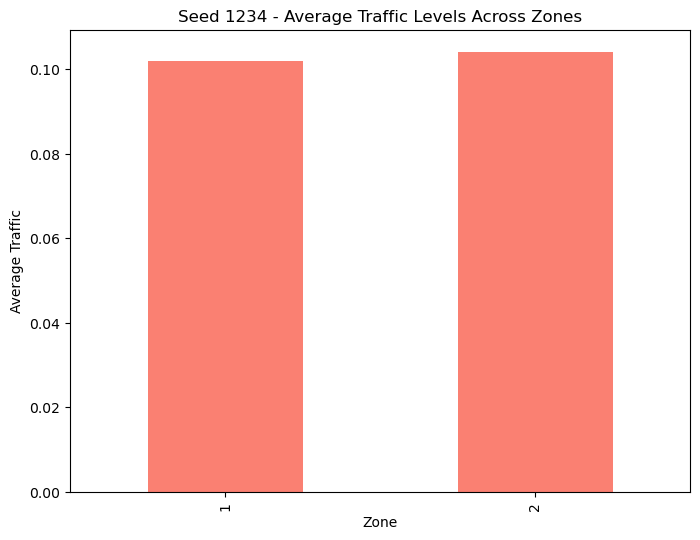

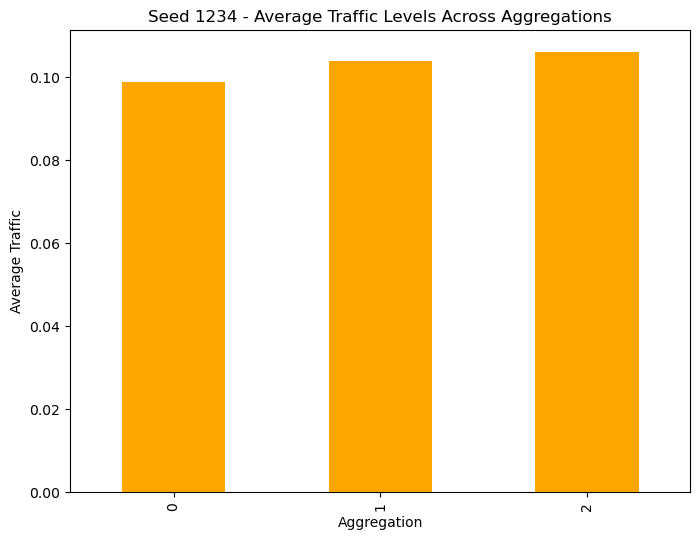

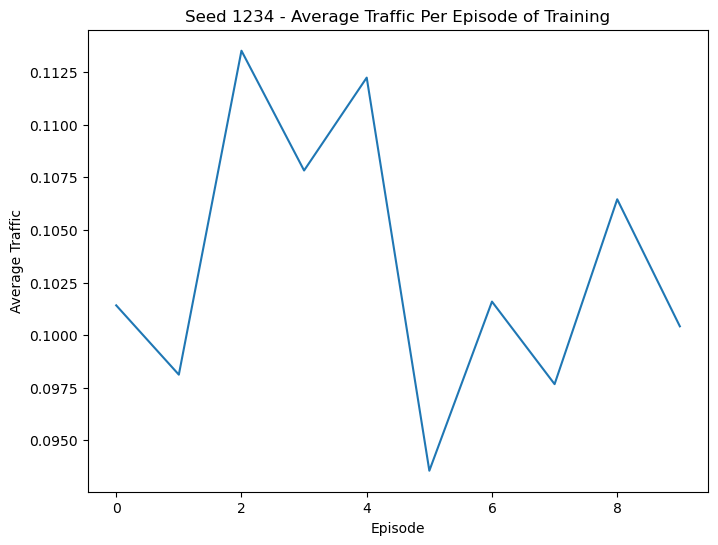

<Figure size 800x600 with 0 Axes>

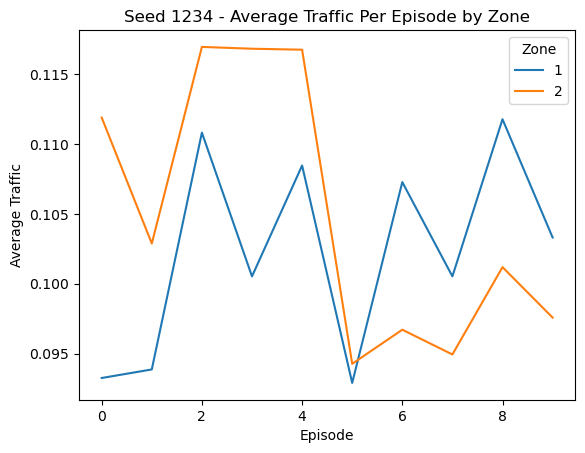

<Figure size 800x600 with 0 Axes>

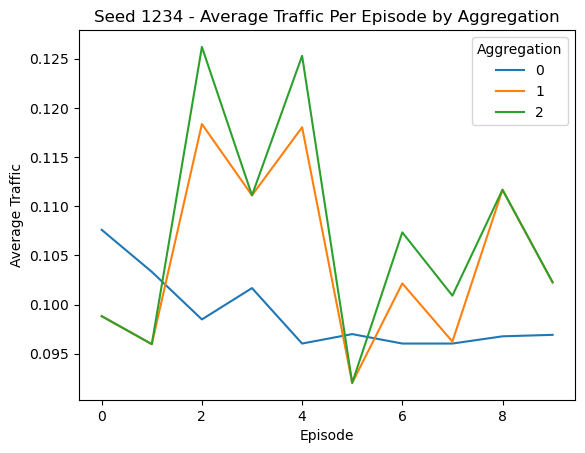

In [6]:
specific = "metrics/metrics_5_10_1234_learned"

if specific == None:
    for seed in env_c['seeds']:
        # Generate the plots for the various metrics
        evaluate(ev_info, None, seed, date, eval_c['verbose'], 'display', f"metrics/metrics_{env_c['num_of_agents']}_{nn_c['num_episodes']}_{seed}_{attr_label}")

else:
    evaluate(ev_info, None, seed, date, eval_c['verbose'], 'display', specific)